In [1]:
from os import path

from astropy.constants import c
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook')
%matplotlib inline
from scipy.optimize import minimize

from comoving_rv.log import logger
from comoving_rv.db import Session, Base, db_connect
from comoving_rv.db.model import (Run, Observation, TGASSource, SimbadInfo, PriorRV,
                                  SpectralLineInfo, SpectralLineMeasurement)

In [2]:
base_path = '/Volumes/ProjectData/gaia-comoving-followup/'
db_path = path.join(base_path, 'db.sqlite')
engine = db_connect(db_path)
session = Session()

In [3]:
Halpha, = session.query(SpectralLineInfo.wavelength).filter(SpectralLineInfo.name == 'Halpha').one()

For now, only get observations that are done that have a Simbad RV already in the database

In [4]:
q = session.query(Observation).join(Run, SpectralLineMeasurement, PriorRV)
q = q.filter(Run.name == 'mdm-spring-2017')
q = q.filter(SpectralLineMeasurement.x0 != None)
q = q.filter(PriorRV.rv != None)
q.distinct().count()

155

In [5]:
observations = q.all()

In [6]:
raw_offsets = np.zeros(len(observations)) * u.angstrom
all_sky_offsets = np.full((len(observations), 3), np.nan) * u.angstrom
true_rv = np.zeros(len(observations)) * u.km/u.s
meas_rv = np.zeros(len(observations)) * u.km/u.s
night_id = np.zeros(len(observations), dtype=int)
obs_time = np.zeros(len(observations))
airmass = np.zeros(len(observations))
hour_angle = np.zeros(len(observations))
color_by = np.zeros(len(observations))

for i,obs in enumerate(observations):
    print(obs.object, obs.filename_1d)
    
    # color_by[i] = obs.airmass
    # color_by[i] = obs.exptime
    
    obs_time[i] = np.sum(np.array(list(map(float, obs.time_obs.split(':')))) / np.array([1., 60., 3600.]))
    color_by[i] = obs_time[i]
    night_id[i] = obs.night
    airmass[i] = obs.airmass
    hour_angle[i] = obs.ha.degree

    x0 = obs.measurements[0].x0 * u.angstrom
    offset = (x0 - Halpha)
    raw_offsets[i] = offset
    
    sky_offsets = []
    for j,meas in enumerate(obs.measurements[1:]):
        sky_offset = meas.x0*u.angstrom - meas.info.wavelength
        if meas.amp > 16 and meas.std_G < 2 and meas.std_G > 0.3 and np.abs(sky_offset) < 4*u.angstrom:
            sky_offsets.append(sky_offset)
            all_sky_offsets[i,j] = sky_offset
            print(meas.info.name, meas.x0, meas.amp, sky_offset)
            
    sky_offsets = u.Quantity(sky_offsets)
    
    if len(sky_offsets) > 0:
        sky_offset = np.mean(sky_offsets)
    else:
        sky_offset = 0. * u.angstrom
        print("WARNING: not correcting with sky line")
    
    # sky_offset = -1.2*u.angstrom
    meas_rv[i] = (offset - sky_offset) / Halpha * c.to(u.km/u.s) + obs.v_bary
    true_rv[i] = obs.prior_rv.rv - obs.v_bary
    print(meas_rv[i] - true_rv[i])
    print()

1243-5711 1d_n1.0034.fit
[OI] 5577 5577.894895342597 106.64093466986985 0.5561953425967658 Angstrom
[OI] 6300 6300.722636191856 46.019564017326076 0.41863619185551215 Angstrom
-32.19755408050325 km / s

1243-1392 1d_n1.0035.fit
[OI] 5577 5577.99269502419 282.1828313360044 0.6539950241894985 Angstrom
[OI] 6364 6364.680487501012 20.442800447307768 0.9044875010122269 Angstrom
-62.98155832700147 km / s

392-10134 1d_n1.0038.fit
[OI] 5577 5578.035563976712 143.0788006557491 0.6968639767119384 Angstrom
[OI] 6300 6300.945222224586 45.1043976928295 0.6412222245862722 Angstrom
-41.33351110142242 km / s

1219-1353 1d_n1.0059.fit
[OI] 5577 5576.050638745876 908.1829559557491 -1.2880612541239316 Angstrom
[OI] 6300 6299.224065818754 24.21443888860573 -1.0799341812462444 Angstrom
-19.328214628804254 km / s

1254-1407 1d_n1.0089.fit
[OI] 5577 5576.667122907217 228.2631511246277 -0.6715770927830818 Angstrom
[OI] 6300 6299.212950861496 31.82249552509176 -1.0910491385038767 Angstrom
4.7081179516255744 k

[OI] 5577 5576.396146383426 249.91019127503097 -0.9425536165745143 Angstrom
[OI] 6300 6298.764185333848 31.29758933456595 -1.5398146661518695 Angstrom
[OI] 6364 6363.519593417264 32.50024572719138 -0.256406582735508 Angstrom
31.58272326459469 km / s

HIP77536 1d_n3.0178.fit
[OI] 5577 5575.907354116793 117.59742935113536 -1.4313458832075412 Angstrom
[OI] 6300 6299.131346146165 20.549315903602203 -1.1726538538350724 Angstrom
68.85852622913625 km / s

HIP76899 1d_n3.0179.fit
[OI] 5577 5576.028240739213 194.96029577022355 -1.3104592607869563 Angstrom
[OI] 6300 6298.741624943356 27.146091405799478 -1.5623750566437593 Angstrom
58.36746287778814 km / s

HIP79137 1d_n3.0181.fit
-5.553368031731136 km / s

HIP79792 1d_n3.0182.fit
[OI] 5577 5575.99526019933 258.00721604156115 -1.3434398006702395 Angstrom
[OI] 6300 6298.929031770182 32.47738360230352 -1.374968229818478 Angstrom
61.09718631749321 km / s

2928-4758 1d_n3.0185.fit
[OI] 5577 5575.490693012189 56.539030023105155 -1.8480069878114591 Ang

[OI] 5577 5578.616041721906 97.11146557484399 1.277341721905941 Angstrom
[OI] 6300 6302.328577973731 160.97611170478024 2.0245779737306293 Angstrom
[OI] 6364 6365.450897760229 49.122642122213506 1.6748977602292143 Angstrom
-25.169695419284153 km / s

1585-1992 1d_n4.0052.fit
[OI] 5577 5577.990728117048 129.89425955189782 0.6520281170478484 Angstrom
-9.231949214279439 km / s

1678-6580 1d_n4.0055.fit
[OI] 5577 5576.875717690952 141.08367061540795 -0.46298230904812954 Angstrom
[OI] 6300 6301.293967023708 18.534649841299444 0.9899670237082319 Angstrom
-3.9323658069404956 km / s

1955-2709 1d_n4.0057.fit
[OI] 5577 5576.582463212374 191.06066279650398 -0.7562367876262215 Angstrom
4.638090085090161 km / s

1509-1819 1d_n4.0060.fit
[OI] 5577 5575.983431026326 92.62850714357687 -1.355268973674356 Angstrom
8.475863360549347 km / s

1852-2500 1d_n4.0073.fit
[OI] 5577 5575.391913258075 271.25100650799 -1.9467867419252798 Angstrom
39.06330189578742 km / s

645-4956 1d_n4.0089.fit
[OI] 5577 5576.00

In [7]:
raw_rv = raw_offsets / Halpha * c.to(u.km/u.s)

### This is just total insanity

/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


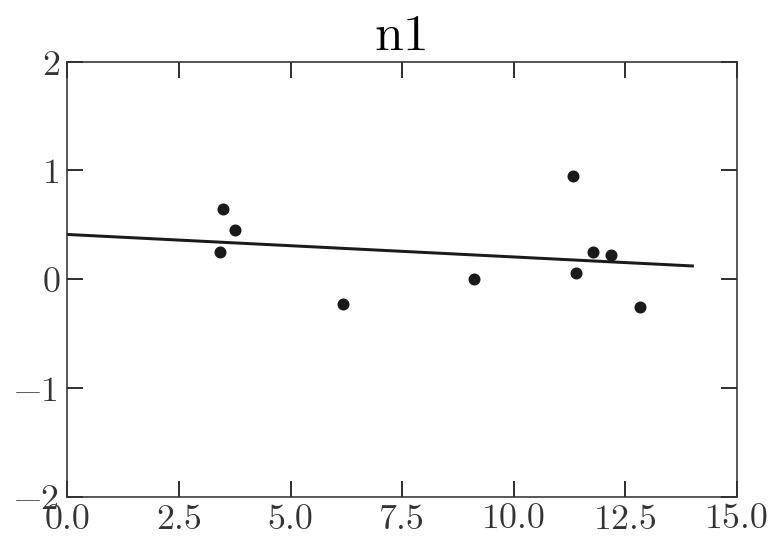

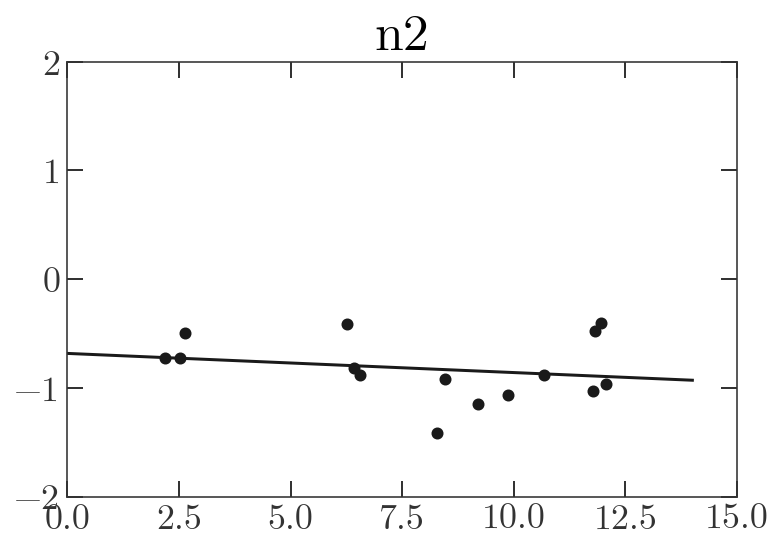

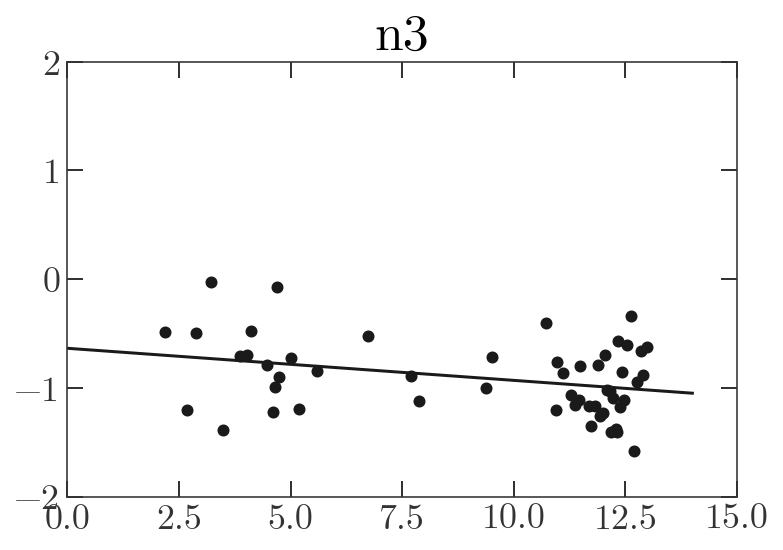

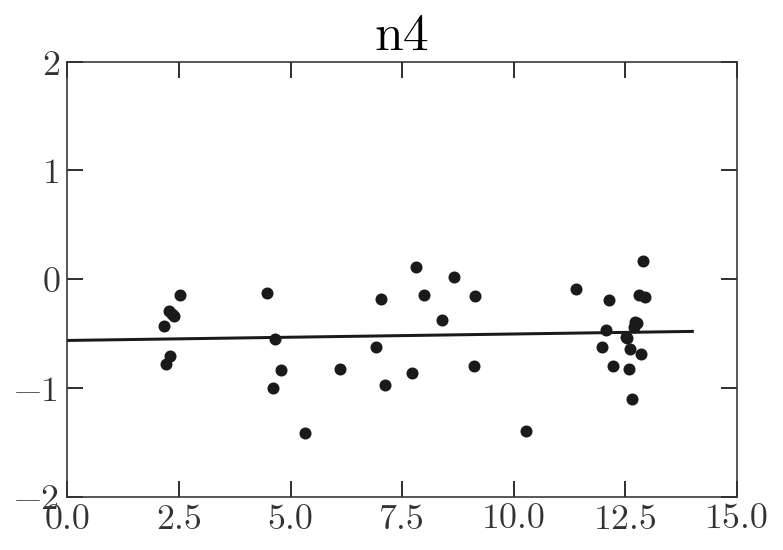

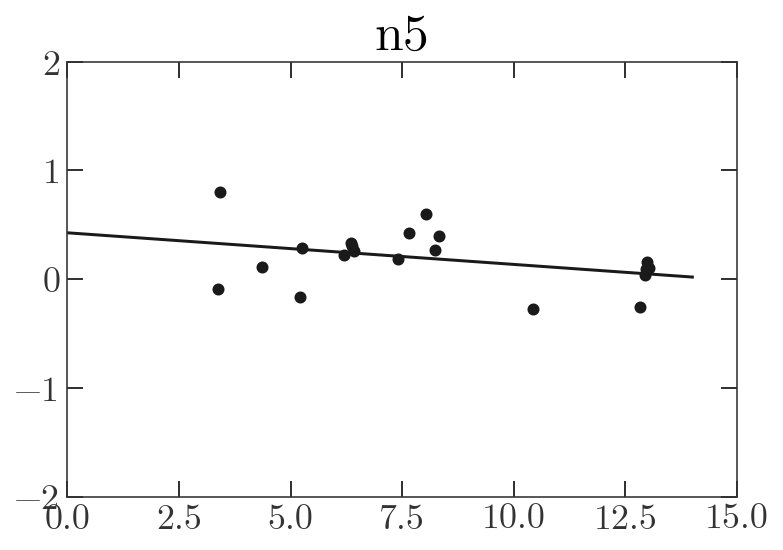

In [8]:
grid = np.linspace(0, 14, 256)

diff = all_sky_offsets[:,0] - ((raw_rv - true_rv)/c*5577*u.angstrom).decompose()
# diff = all_sky_offsets[:,0] - ((meas_rv - true_rv)/c*5577*u.angstrom).decompose()
diff[np.abs(diff) > 2*u.angstrom] = np.nan * u.angstrom

night_polys = dict()
for n in range(1,5+1):
    mask = (night_id == n) & np.isfinite(diff)
    coef = np.polyfit(obs_time[mask], diff[mask], deg=1, w=np.full(mask.sum(), 1/0.1))
    poly = np.poly1d(coef)
    night_polys[n] = poly
    
    plt.figure()
    sc = plt.scatter(obs_time[mask], diff[mask])
    plt.plot(grid, poly(grid), color=sc.get_facecolor()[0], marker='')
    plt.title('n{}'.format(n))
    plt.xlim(-0, 15)
    plt.ylim(-2, 2)

In [13]:
corrected_rv = np.zeros(len(observations)) * u.km/u.s
derps = dict()
for n in np.unique(night_id):
    mask = night_id == n
    
    sky_offset = np.nanmean(all_sky_offsets[mask,:2], axis=1)
    sky_offset[np.isnan(sky_offset)] = 0.*u.angstrom
    sky_offset -= night_polys[n](obs_time[mask]) * u.angstrom
    
    corrected_rv[mask] = (raw_offsets[mask] - sky_offset) / Halpha * c.to(u.km/u.s)
    
for n in np.unique(night_id):
    mask = night_id == n
    derps[n] = np.nanmedian(corrected_rv[mask] - true_rv[mask])
    corrected_rv[mask] = corrected_rv[mask] - derps[n]

/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice


1 3.552713678800501e-15 km / s 12.83077081667797 km / s -5.317430253290531 km / s 18.083199736948277 km / s
2 8.881784197001252e-16 km / s 20.306247108750355 km / s -0.4991440179204223 km / s 20.50983159447169 km / s
3 0.0 km / s 14.26683123491049 km / s -27.64453876962776 km / s 218.49511498352547 km / s
4 -1.7763568394002505e-15 km / s 26.645769129012287 km / s 0.5074959045001305 km / s 27.269025595406166 km / s
5 0.0 km / s 9.964899061285529 km / s -3.9240886144039187 km / s 20.661927588327057 km / s
total: 16.740214555302778 km / s 17.40339460245057 km / s


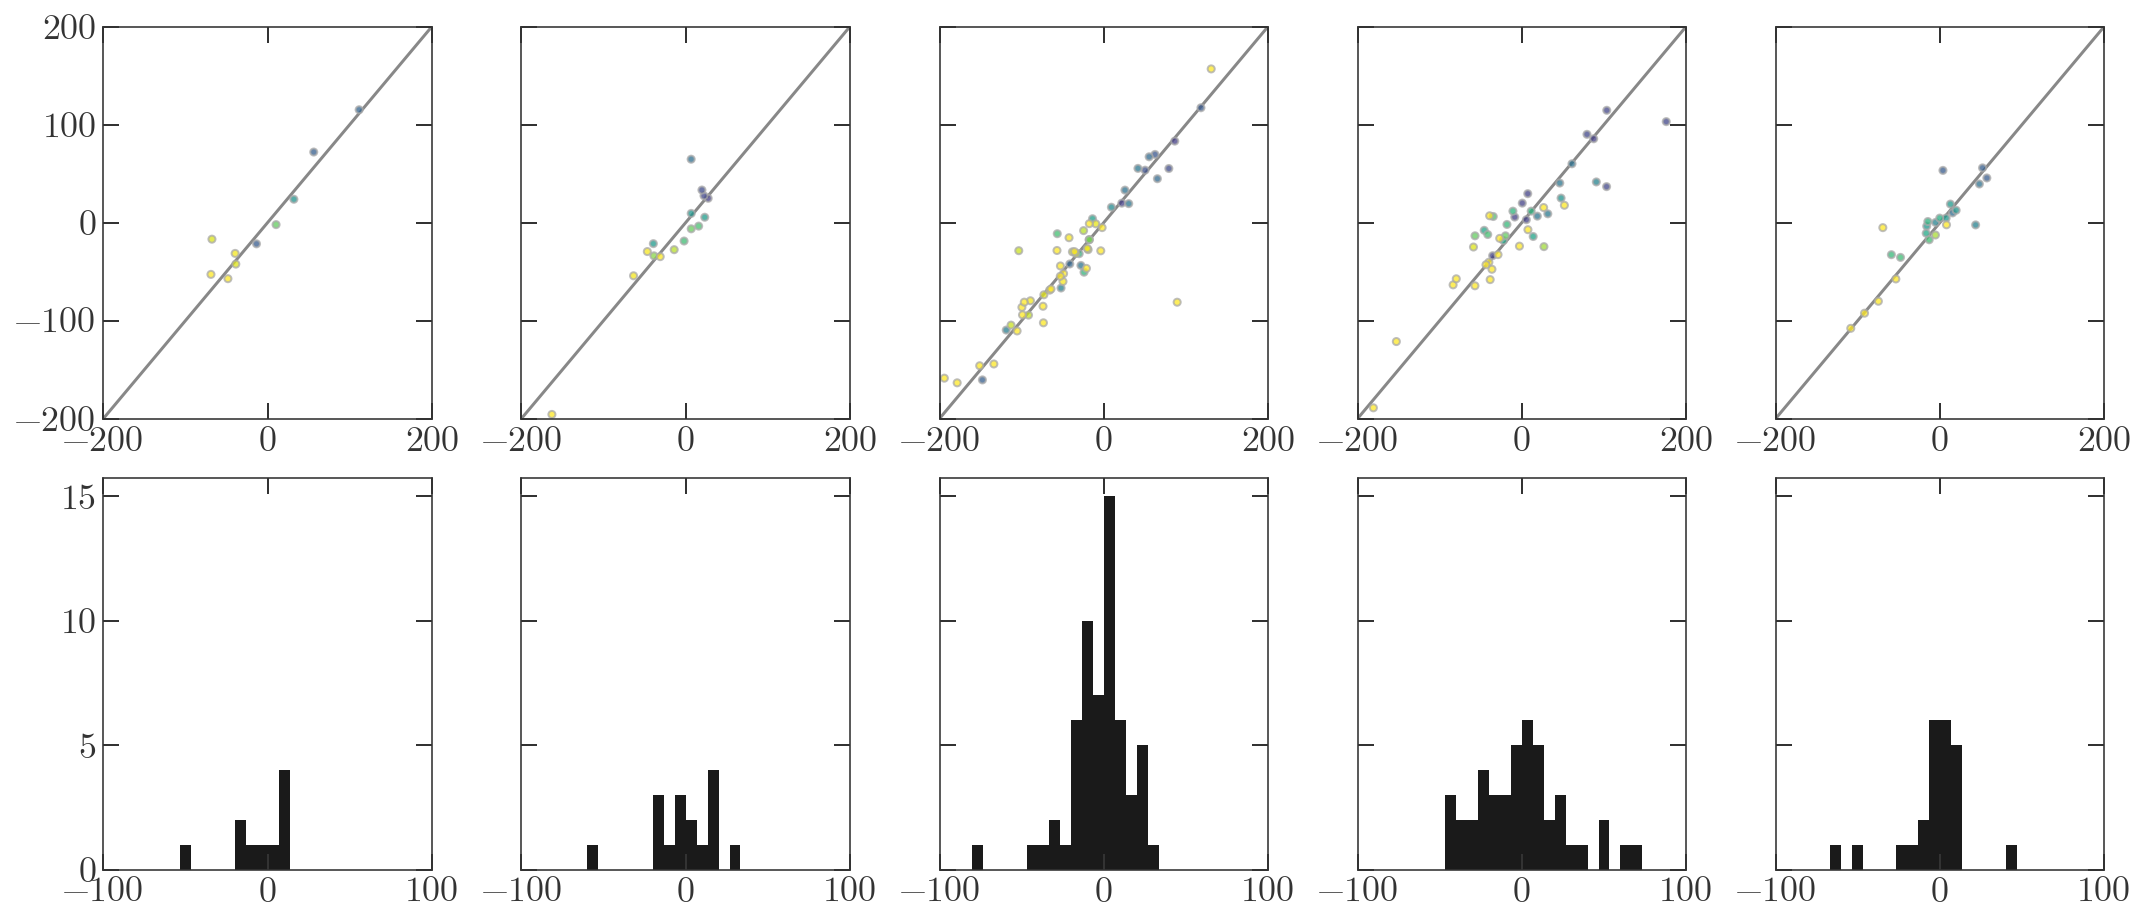

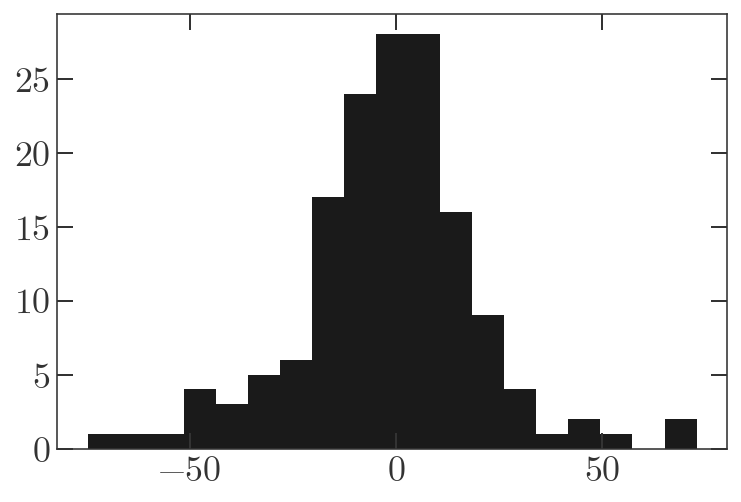

In [14]:
fig,axes = plt.subplots(2, 5, figsize=(15,6.5), sharex='row', sharey='row')

_lim = (-200, 200)
_grid = np.linspace(_lim[0], _lim[1], 16)
_bins = np.linspace(-100, 100, 31)
for n in range(1,5+1):
    ax = axes[0, n-1]
    
    mask = night_id == n
    
    cb = ax.scatter(corrected_rv[mask], true_rv[mask], c=color_by[mask], 
                    marker='.', alpha=0.75, vmin=0, vmax=12, linewidth=1., 
                    edgecolor='#aaaaaa', s=50)
    ax.plot(_grid, _grid, marker='', zorder=-10, color='#888888')
    
    # histogram
    ax = axes[1, n-1]
    drv = corrected_rv[mask] - true_rv[mask]
    ax.hist(drv, bins=_bins)
    
    print(n, np.median(drv), 1.5 * np.median(np.abs(drv - np.median(drv))), np.mean(drv), np.std(drv))
    
axes[0,0].set_xlim(_lim)
axes[0,0].set_ylim(_lim)
axes[1,0].set_xlim(_bins.min(), _bins.max())

fig.tight_layout()

# all:
drv = corrected_rv - true_rv
print('total:', 1.5 * np.median(np.abs(drv - np.median(drv))), np.std(drv[np.abs(drv) < 50*u.km/u.s]))

plt.figure()
plt.hist(drv[np.abs(drv) < 100*u.km/u.s], bins='auto');

5 0.0 km / s 16.740214555302778 km / s -11.737585669126542 km / s 138.91381527354295 km / s


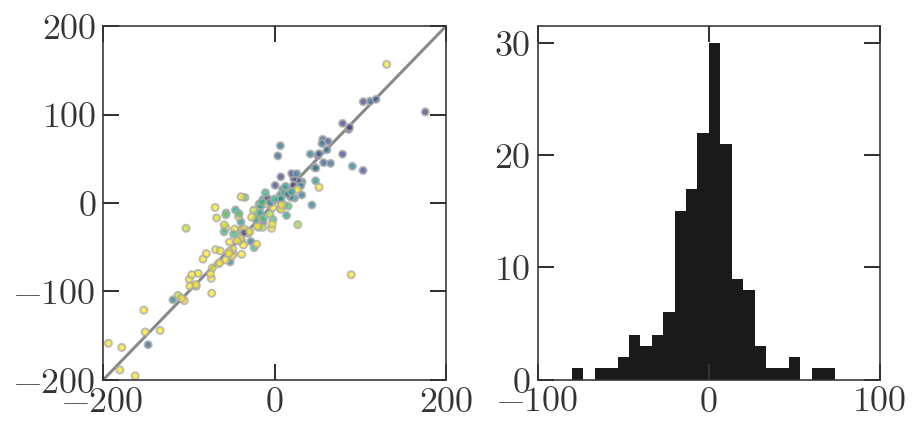

In [21]:
fig,axes = plt.subplots(1, 2, figsize=(6.5, 3.1))

_lim = (-200, 200)
_grid = np.linspace(_lim[0], _lim[1], 16)
_bins = np.linspace(-100, 100, 31)

cb = axes[0].scatter(corrected_rv, true_rv, c=color_by, 
                     marker='.', alpha=0.75, vmin=0, vmax=12, linewidth=1., 
                     edgecolor='#aaaaaa', s=50)
axes[0].plot(_grid, _grid, marker='', zorder=-10, color='#888888')

# histogram
drv = corrected_rv - true_rv
axes[1].hist(drv, bins=_bins)

print(n, np.median(drv), 1.5 * np.median(np.abs(drv - np.median(drv))), np.mean(drv), np.std(drv))
    
axes[0].set_xlim(_lim)
axes[0].set_ylim(_lim)
axes[1].set_xlim(_bins.min(), _bins.max())

fig.tight_layout()

## Do same as above, as a class

In [25]:
class RVCorrector(object):

    def __init__(self, session, run_name):
        self.session = session
        self.run_name = str(run_name)

        # get wavelength for Halpha
        self.Halpha, = session.query(SpectralLineInfo.wavelength)\
                              .filter(SpectralLineInfo.name == 'Halpha').one()

        self._compute_offset_corrections()

    def _compute_offset_corrections(self):
        session = self.session
        run_name = self.run_name

        q = session.query(Observation).join(Run, SpectralLineMeasurement, PriorRV)
        q = q.filter(Run.name == run_name)
        q = q.filter(SpectralLineMeasurement.x0 != None)
        q = q.filter(PriorRV.rv != None)
        logger.debug('{0} observations with prior RV measurements'
                     .format(q.distinct().count()))

        # retrieve all observations with measured centroids and previous RV's
        observations = q.all()

        # What we do below is look at the residual offsets between applying a naïve
        # sky-line correction and the true RV (with the barycentric velocity
        # applied)

        raw_offsets = np.zeros(len(observations)) * u.angstrom
        all_sky_offsets = np.full((len(observations), 3), np.nan) * u.angstrom
        true_rv = np.zeros(len(observations)) * u.km/u.s
        obs_time = np.zeros(len(observations))
        night_id = np.zeros(len(observations), dtype=int)
        corrected_rv = np.zeros(len(observations)) * u.km/u.s

        for i,obs in enumerate(observations):
            # convert obstime into decimal hour
            obs_time[i] = np.sum(np.array(list(map(float, obs.time_obs.split(':')))) / np.array([1., 60., 3600.]))

            # Compute the raw offset: difference between Halpha centroid and true
            # wavelength value
            x0 = obs.measurements[0].x0 * u.angstrom
            offset = (x0 - self.Halpha)
            raw_offsets[i] = offset

            night_id[i] = obs.night

            # For each sky line (that passes certain quality checks), compute the
            # offset between the predicted wavelength and measured centroid
            # TODO: generalize these quality cuts - see also below in
            # get_corrected_rv
            sky_offsets = []
            for j,meas in enumerate(obs.measurements[1:]):
                sky_offset = meas.x0*u.angstrom - meas.info.wavelength
                if (meas.amp > 16 and meas.std_G < 2 and meas.std_G > 0.3 and
                        np.abs(sky_offset) < 4*u.angstrom): # MAGIC NUMBER: quality cuts
                    sky_offsets.append(sky_offset)
                    all_sky_offsets[i,j] = sky_offset

            sky_offsets = u.Quantity(sky_offsets)

            if len(sky_offsets) > 0:
                sky_offset = np.mean(sky_offsets)
            else:
                sky_offset = np.nan * u.angstrom
                logger.debug("not correcting with sky line for {0}".format(obs))

            true_rv[i] = obs.prior_rv.rv - obs.v_bary

        raw_rv = raw_offsets / self.Halpha * c.to(u.km/u.s)

        # unique night ID's
        unq_night_id = np.unique(night_id)
        unq_night_id.sort()

        # Now we do a totally insane thing. From visualizing the residual
        # differences, there seems to be a trend with the observation time. We
        # fit a line to these residuals and use this to further correct the
        # wavelength solutions using just the (strongest) [OI] 5577 Å line.
        diff = all_sky_offsets[:,0] - ((raw_rv - true_rv)/c*5577*u.angstrom).decompose()
        diff[np.abs(diff) > 2*u.angstrom] = np.nan * u.angstrom # reject BIG offsets

        self._night_polys = dict()
        self._night_final_offsets = dict()
        for n in unq_night_id:
            mask = (night_id == n) & np.isfinite(diff)
            coef = np.polyfit(obs_time[mask], diff[mask], deg=1, w=np.full(mask.sum(), 1/0.1))
            poly = np.poly1d(coef)
            self._night_polys[n] = poly

            sky_offset = np.nanmean(all_sky_offsets[mask,:2], axis=1)
            sky_offset[np.isnan(sky_offset)] = 0.*u.angstrom
            sky_offset -= self._night_polys[n](obs_time[mask]) * u.angstrom

            corrected_rv[mask] = (raw_offsets[mask] - sky_offset) / self.Halpha * c.to(u.km/u.s)

            # Finally, we align the median of each night's ∆RV distribution with 0
            drv = corrected_rv[mask] - true_rv[mask]
            self._night_final_offsets[n] = np.nanmedian(drv)

        # now estimate the std. dev. uncertainty using the MAD
        all_drv = corrected_rv - true_rv
        self._abs_err = 1.5 * np.nanmedian(np.abs(all_drv - np.nanmedian(all_drv)))

    def get_corrected_rv(self, obs):
        """Compute a corrected radial velocity for the given observation"""

        # Compute the raw offset: difference between Halpha centroid and true
        # wavelength value
        x0 = obs.measurements[0].x0 * u.angstrom
        raw_offset = (x0 - self.Halpha)

        # precision estimate from line centroid error
        precision = (obs.measurements[0].x0_error* u.angstrom) / self.Halpha * c.to(u.km/u.s)

        # For each sky line (that passes certain quality checks), compute the
        # offset between the predicted wavelength and measured centroid
        # TODO: generalize these quality cuts - see also above in
        # _compute_offset_corrections
        sky_offsets = np.full(3, np.nan) * u.angstrom
        for j,meas in enumerate(obs.measurements[1:]):
            sky_offset = meas.x0*u.angstrom - meas.info.wavelength
            if (meas.amp > 16 and meas.std_G < 2 and meas.std_G > 0.3 and
                    np.abs(sky_offset) < 3.3*u.angstrom): # MAGIC NUMBER: quality cuts
                sky_offsets[j] = sky_offset

        # final sky offset to apply
        flag = 0
        sky_offset = np.nanmean(sky_offsets)
        if np.isnan(sky_offset.value):
            logger.debug("not correcting with sky line for {0}".format(obs))
            sky_offset = 0*u.angstrom
            flag = 1

        # apply global sky offset correction - see _compute_offset_corrections()
        sky_offset -= self._night_polys[obs.night](obs.utc_hour) * u.angstrom

        # compute radial velocity and correct for sky line
        rv = (raw_offset - sky_offset) / self.Halpha * c.to(u.km/u.s)

        # correct for offset of median of ∆RV distribution from targets with
        # prior/known RV's
        rv -= self._night_final_offsets[obs.night]

        # rv error
        err = np.sqrt(self._abs_err**2 + precision**2)

        return rv, err, flag

In [26]:
rv_corr = RVCorrector(session, 'mdm-spring-2017')

/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/ipykernel/__main__.py:82: RuntimeWarning: invalid value encountered in greater


In [27]:
corrected_rv2 = np.zeros_like(corrected_rv)
err = np.zeros_like(corrected_rv)
flags = np.zeros(len(corrected_rv2))
for i,obs in enumerate(observations):
    corrected_rv2[i], err[i], flags[i] = rv_corr.get_corrected_rv(obs)

/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/ipykernel/__main__.py:130: RuntimeWarning: Mean of empty slice


1 3.552713678800501e-15 km / s 15.434787892158447 km / s -5.188222367473427 km / s 19.161373965875086 km / s
2 -5.101770897317557 km / s 13.947159816416535 km / s -3.893017368133714 km / s 12.472618569546832 km / s
3 -0.593009319040096 km / s 14.17957139123754 km / s -28.259440367420815 km / s 223.97320731438626 km / s
4 -0.17479452574242416 km / s 23.193839957437547 km / s -2.653981911852103 km / s 23.35512518456692 km / s
5 -2.458896551060519 km / s 11.794232183910378 km / s -3.7664104748911704 km / s 18.296199177940256 km / s
total: 17.69966812706215 km / s 17.54436628620426 km / s


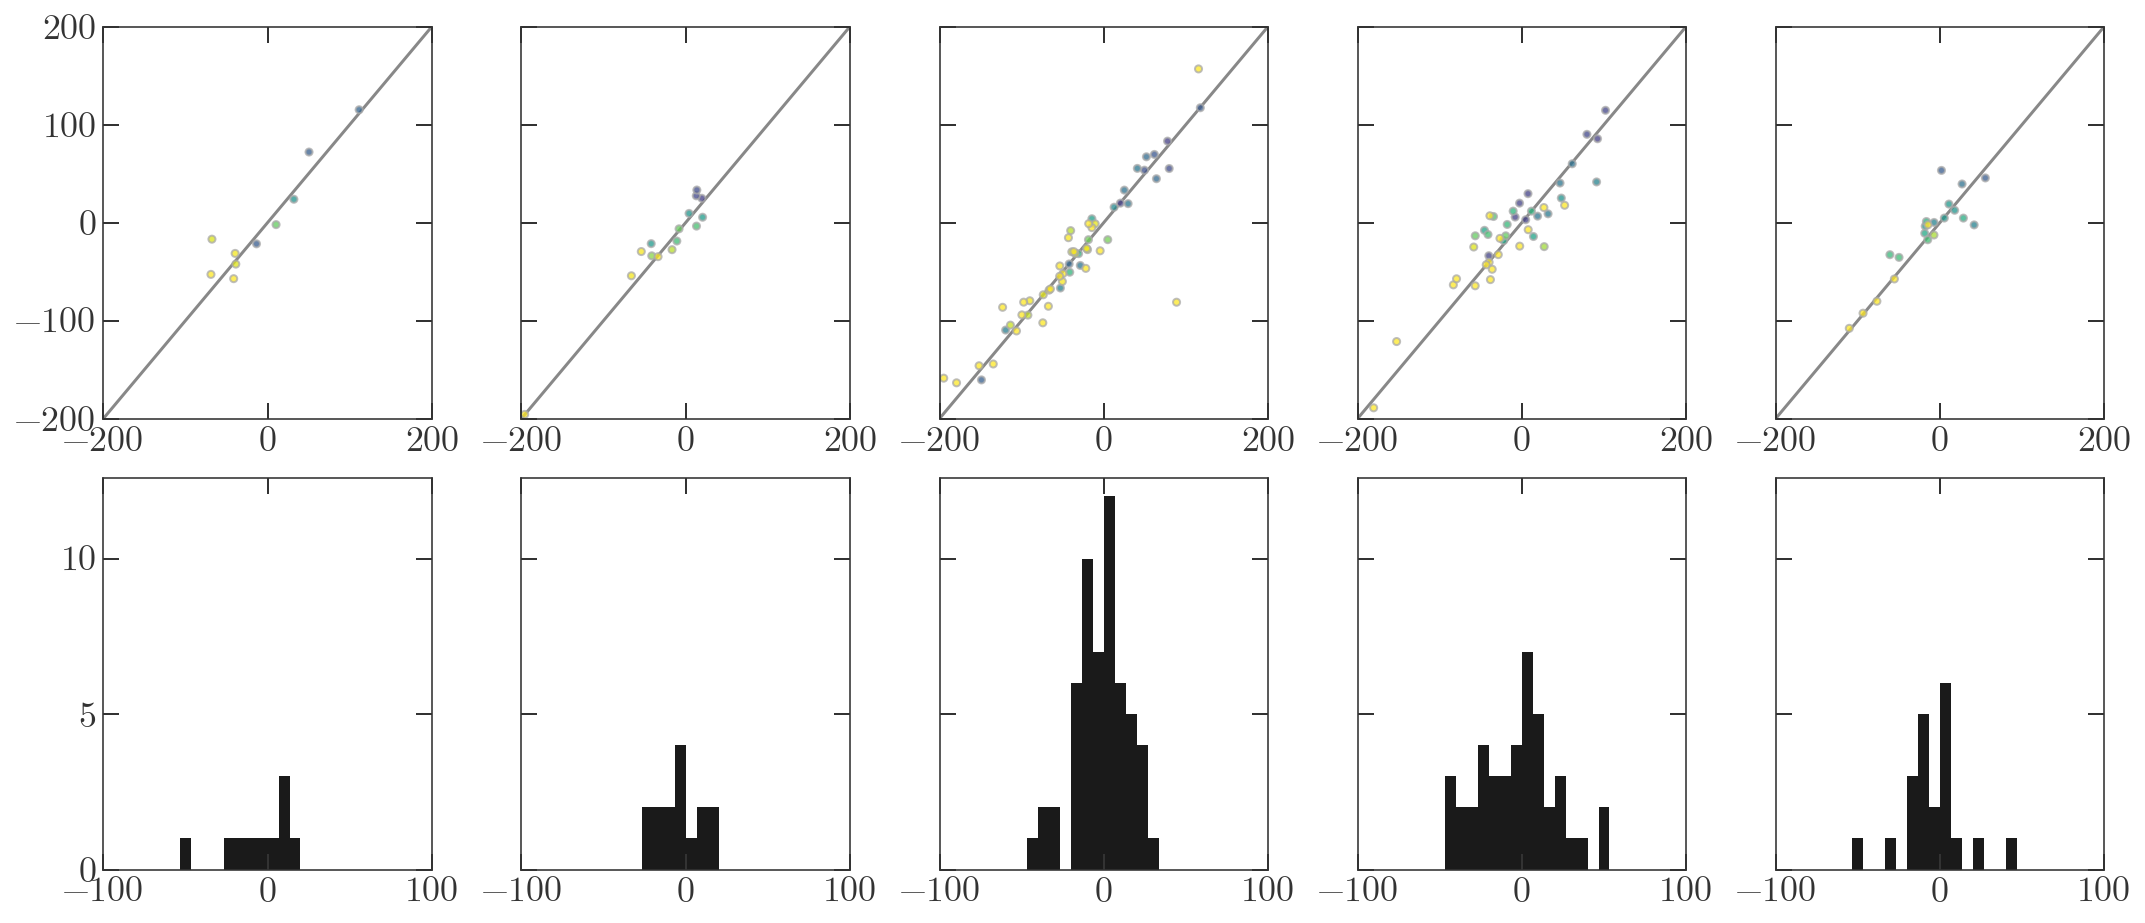

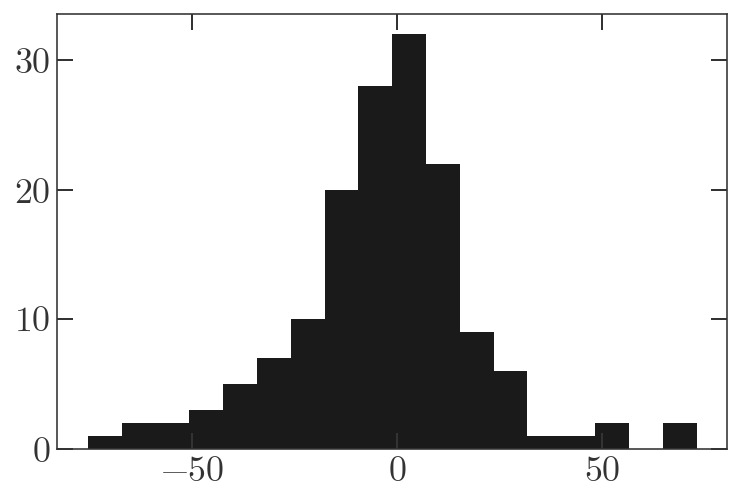

In [28]:
fig,axes = plt.subplots(2, 5, figsize=(15,6.5), sharex='row', sharey='row')

_lim = (-200, 200)
_grid = np.linspace(_lim[0], _lim[1], 16)
_bins = np.linspace(-100, 100, 31)
for n in range(1,5+1):
    ax = axes[0, n-1]
    
    mask = (night_id == n) & (flags == 0)
    cb = ax.scatter(corrected_rv2[mask], true_rv[mask], c=color_by[mask], 
                   marker='.', alpha=0.75, vmin=0, vmax=12, linewidth=1., 
                    edgecolor='#aaaaaa', s=50)
    ax.plot(_grid, _grid, marker='', zorder=-10, color='#888888')
    
    # histogram
    ax = axes[1, n-1]
    drv = corrected_rv2[mask] - true_rv[mask]
    ax.hist(drv, bins=_bins)
    
    print(n, np.median(drv), 1.5 * np.median(np.abs(drv - np.median(drv))), np.mean(drv), np.std(drv))
    
axes[0,0].set_xlim(_lim)
axes[0,0].set_ylim(_lim)
axes[1,0].set_xlim(_bins.min(), _bins.max())

fig.tight_layout()

# all:
drv = corrected_rv2 - true_rv
print('total:', 1.5 * np.median(np.abs(drv - np.median(drv))), np.std(drv[np.abs(drv) < 50*u.km/u.s]))

plt.figure()
plt.hist(drv[np.abs(drv) < 100*u.km/u.s], bins='auto');

5 -2.458896551060519 km / s 17.69966812706215 km / s -13.416429930713512 km / s 138.92575908864254 km / s


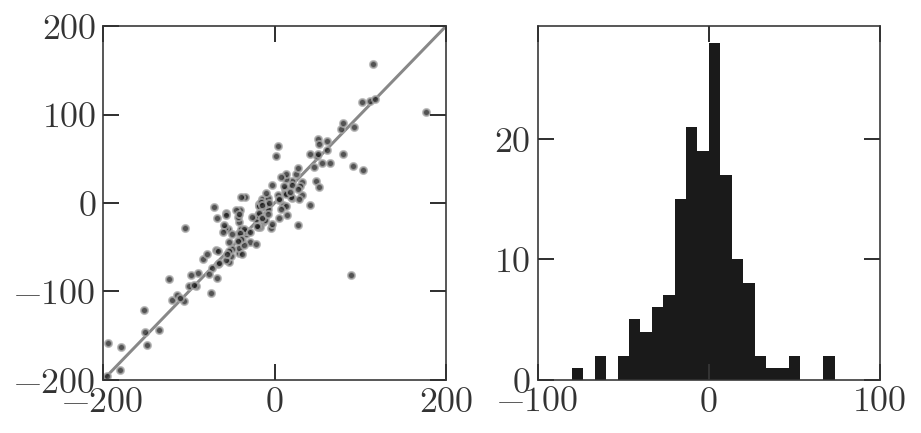

In [30]:
fig,axes = plt.subplots(1, 2, figsize=(6.5, 3.1))

_lim = (-200, 200)
_grid = np.linspace(_lim[0], _lim[1], 16)
_bins = np.linspace(-100, 100, 31)

# cb = axes[0].scatter(corrected_rv2, true_rv, c=color_by, 
#                      marker='.', alpha=0.75, vmin=0, vmax=12, linewidth=1., 
#                      edgecolor='#aaaaaa', s=50)
cb = axes[0].scatter(corrected_rv2, true_rv, 
                     marker='.', alpha=0.75, linewidth=1., 
                     edgecolor='#aaaaaa', s=50)
axes[0].plot(_grid, _grid, marker='', zorder=-10, color='#888888')

# histogram
drv = corrected_rv2 - true_rv
axes[1].hist(drv, bins=_bins)

print(n, np.median(drv), 1.5 * np.median(np.abs(drv - np.median(drv))), np.mean(drv), np.std(drv))
    
axes[0].set_xlim(_lim)
axes[0].set_ylim(_lim)
axes[1].set_xlim(_bins.min(), _bins.max())

fig.tight_layout()

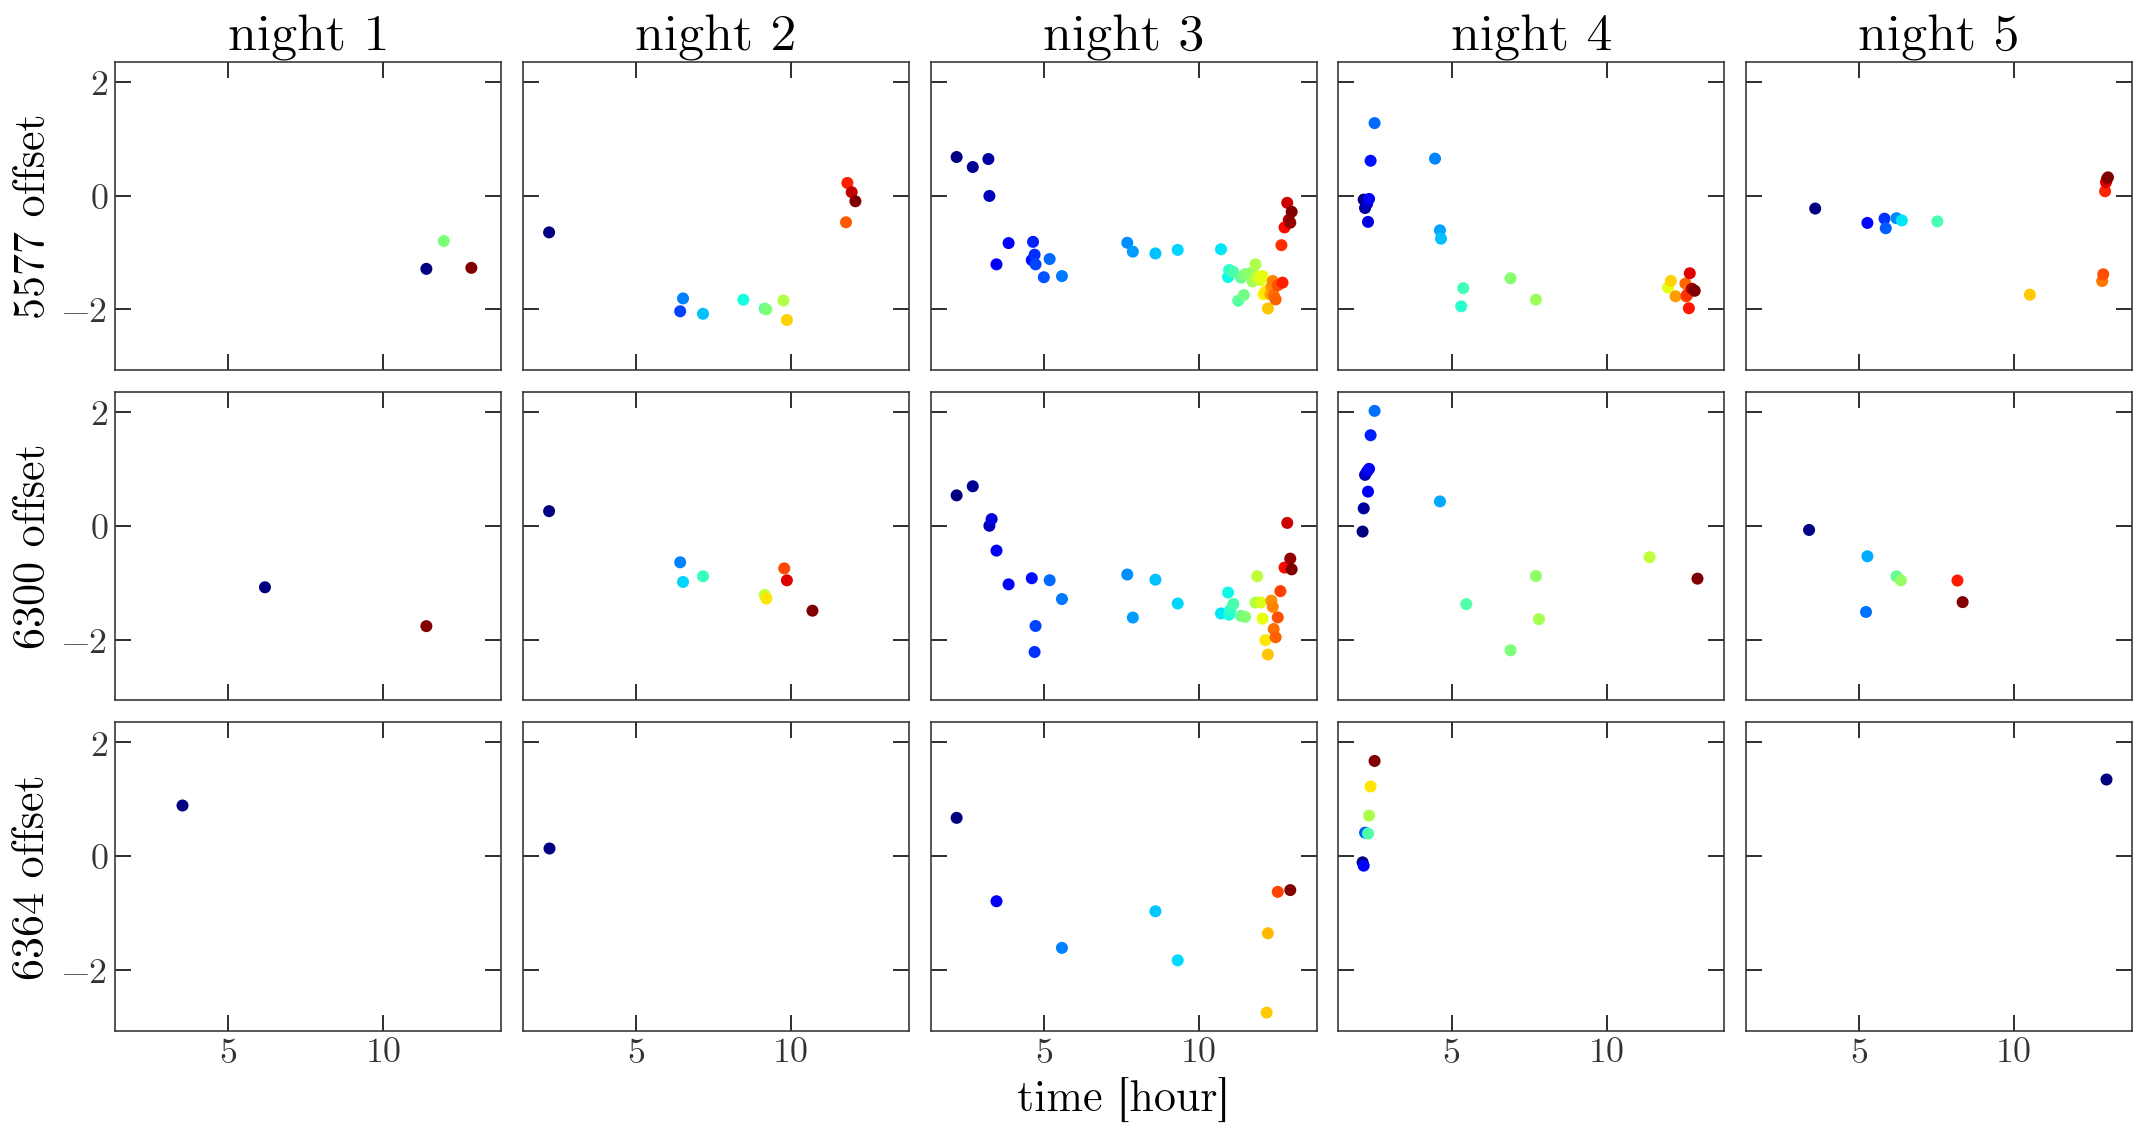

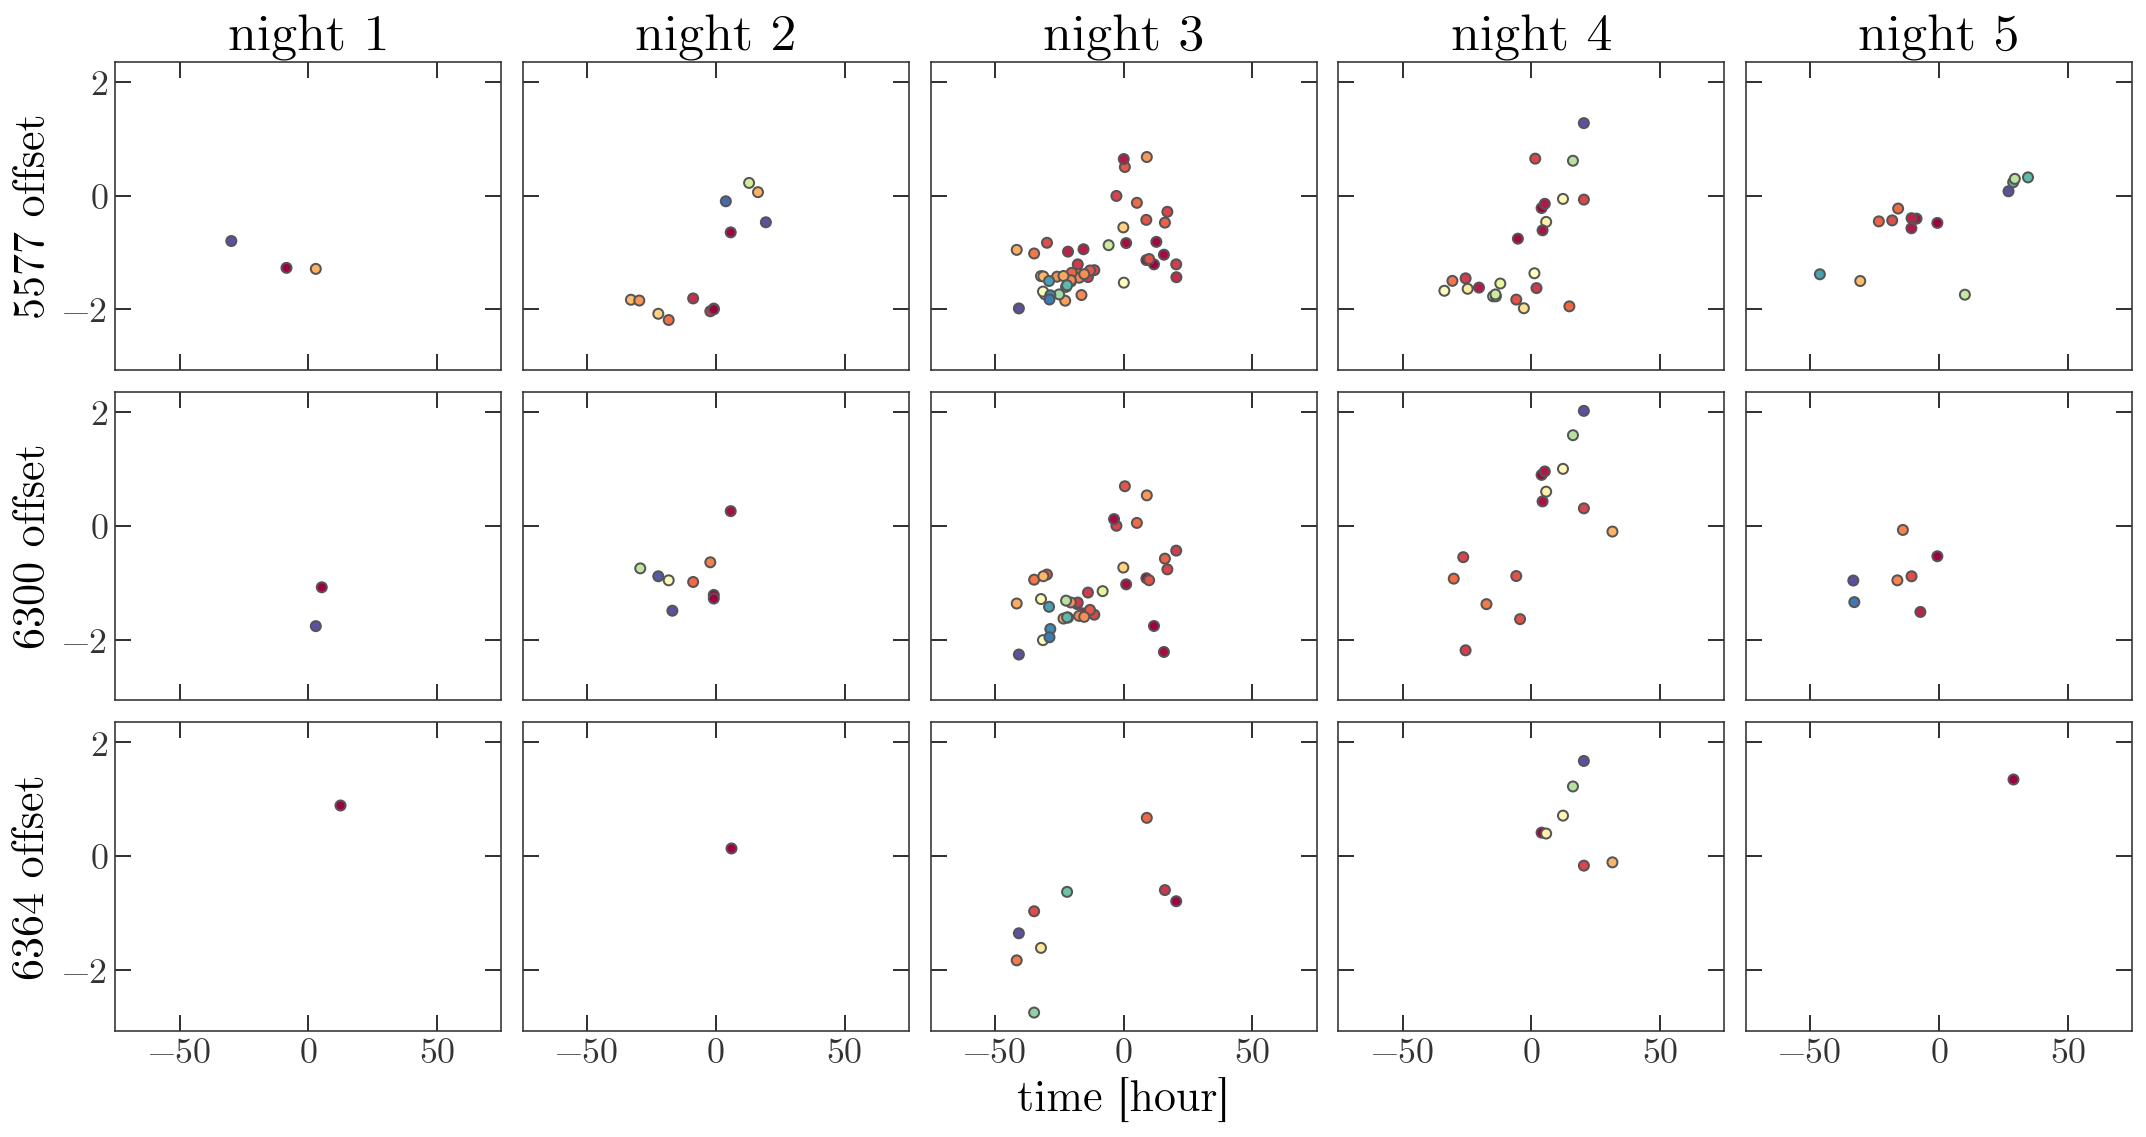

In [128]:
fig,axes = plt.subplots(3, 5, figsize=(15,8), sharex=True, sharey=True)

for n in range(1,5+1):
    ax = axes[:,n-1]
    mask = night_id == n
    
    for j in range(3):
        ax[j].scatter(obs_time[mask], all_sky_offsets[mask,j], c=np.arange(mask.sum()), cmap='jet')
    
    ax[0].set_title('night {0}'.format(n))

axes[2,2].set_xlabel('time [hour]')
axes[0,0].set_ylabel('5577 offset')
axes[1,0].set_ylabel('6300 offset')
axes[2,0].set_ylabel('6364 offset')

fig.tight_layout()

# ---

fig,axes = plt.subplots(3, 5, figsize=(15,8), sharex=True, sharey=True)

for n in range(1,5+1):
    ax = axes[:,n-1]
    mask = night_id == n
    
    for j in range(3):
#         ax[j].scatter(hour_angle[mask], all_sky_offsets[mask,j], c=np.arange(mask.sum()), cmap='jet')
        ax[j].scatter(hour_angle[mask], all_sky_offsets[mask,j], c=airmass[mask], 
                      cmap='Spectral', edgecolor='#555555', linewidth=1)
    
    ax[0].set_title('night {0}'.format(n))

axes[2,2].set_xlabel('time [hour]')
axes[0,0].set_ylabel('5577 offset')
axes[1,0].set_ylabel('6300 offset')
axes[2,0].set_ylabel('6364 offset')

axes[0,0].set_xlim(-75, 75)

fig.tight_layout()

In [138]:
((raw_rv - true_rv)[mask]/c*5577).decompose()

<Quantity [ 0.20122337, 0.04386244, 0.29430355, 0.23662698, 0.13507043,
           -0.41822142,-0.52730527,-0.3262756 ,-0.50606495,-0.61870854,
           -0.66404279,-0.67688848,-0.72295722,-0.85432606,-1.098773  ,
           -0.84358084,-0.8218817 ,-0.93172964,-1.21292571,-1.35292467,
           -1.56569791,-2.52852086,-0.39260151,-0.26459427,-0.24483261,
           -0.12367286]>

(-2.5, 2.5)

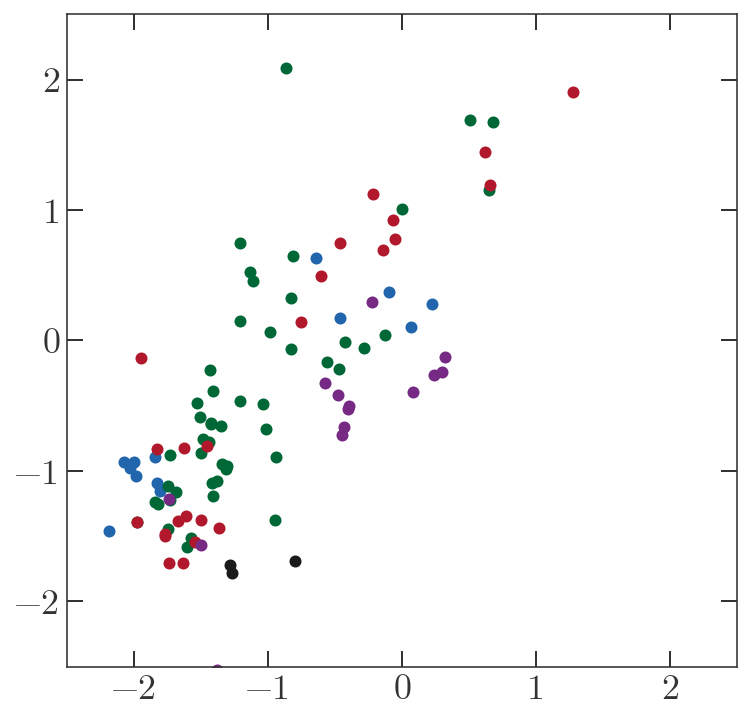

In [145]:
plt.figure(figsize=(6,6))

for n in range(1,5+1):
    mask = night_id == n
    plt.scatter(all_sky_offsets[mask,0], 
                ((raw_rv - true_rv)[mask]/c*5577).decompose())
plt.xlim(-2.5,2.5)
# plt.ylim(-150,150)
plt.ylim(-2.5,2.5)

---

# Take a peek at velocity differences

In [71]:
q = session.query(Observation.group_id).join(Run, SpectralLineMeasurement)
q = q.filter(Run.name == 'mdm-spring-2017')
print(q.distinct().count())
gids = np.array([gid for gid, in q.distinct().all()])

288


In [74]:
rv_diffs = []
all_x0s = []
for gid in gids:
    meas_q = session.query(SpectralLineMeasurement).join(Observation, SpectralLineInfo)
    meas_q = meas_q.filter(SpectralLineInfo.name == 'Halpha')
    meas_q = meas_q.filter(Observation.group_id == gid)
    x0s = [meas.x0 for meas in meas_q.all()]
    
    if len(x0s) == 2:
        rv_diff = (x0s[1] - x0s[0])*u.angstrom / Halpha * c.to(u.km/u.s)
        rv_diffs.append(rv_diff)
        
        all_x0s = all_x0s + x0s
    
    else:
        rv_diffs.append(np.nan*u.km/u.s)
        
rv_diffs = u.Quantity(rv_diffs)
all_x0s = u.Quantity(all_x0s)

In [75]:
# random shuffle
# TODO: redo this after correcting for barycenter, sky shifts, etc.
_derp = np.random.choice(len(all_x0s), size=len(all_x0s), replace=False)
random_rv_diff = (all_x0s - all_x0s[_derp])*u.angstrom / Halpha * c.to(u.km/u.s)

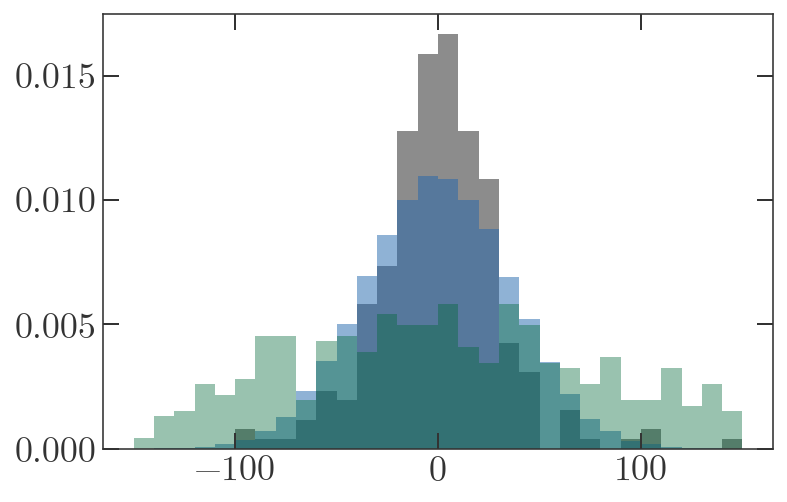

In [76]:
_,bins,_ = plt.hist(rv_diffs[np.isfinite(rv_diffs)], bins=np.linspace(-150, 150, 31), 
                    normed=True, alpha=0.5)

plt.hist(np.random.normal(0, np.sqrt(25**2 + 25**2 + 5**2 + 5**2), size=64000), 
         bins=bins, normed=True, alpha=0.5);

_,bins,_ = plt.hist(random_rv_diff[np.isfinite(random_rv_diff)], bins=bins, normed=True, alpha=0.4)

Now look at differences in sky lines

In [48]:
sky_diffs = []
for gid in gids:
    meas_q = session.query(SpectralLineMeasurement).join(Observation, SpectralLineInfo)
    meas_q = meas_q.filter(SpectralLineInfo.name == '[OI] 6300')
    meas_q = meas_q.filter(Observation.group_id == gid)
    x0s = [meas.x0 for meas in meas_q.all()]

    if len(x0s) == 2:
        sky_diff = (x0s[1] - x0s[0])*u.angstrom / (6300*u.angstrom) * c.to(u.km/u.s)
        sky_diffs.append(sky_diff)
    
    else:
        sky_diffs.append(np.nan*u.km/u.s)
    
sky_diffs = u.Quantity(sky_diffs)

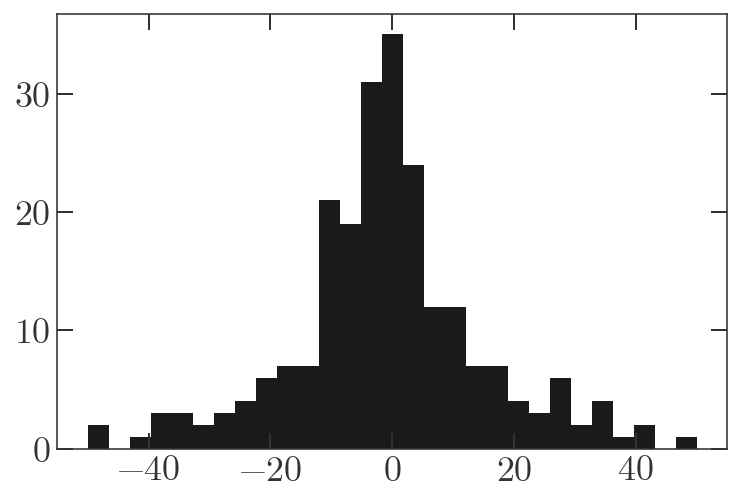

In [49]:
plt.hist(sky_diffs[np.isfinite(sky_diffs)], bins=np.linspace(-50, 50, 30));

TODO: ok, so apparently I need to correct for sky line shifts before doing RV difference??

In [18]:
seps = []
for gid in gids[np.isfinite(rv_diffs) & (rv_diffs < 15*u.km/u.s)]:
    _q = session.query(TGASSource).join(Observation)
    _q = _q.filter(Observation.group_id == gid)
    tgas_data = _q.all()
    
    c1 = tgas_data[0].skycoord
    c2 = tgas_data[1].skycoord
    
    sep = c1.separation_3d(c2)
    seps.append(sep)

seps = u.Quantity(seps)

/Users/adrian/anaconda/envs/comoving-rv/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


(array([  9.,   9.,   8.,  23.,  24.,  23.,  45.,  20.,   3.]),
 array([  0.0785138 ,   1.39608266,   2.71365152,   4.03122038,
          5.34878924,   6.6663581 ,   7.98392696,   9.30149583,
         10.61906469,  11.93663355]),
 <a list of 9 Patch objects>)

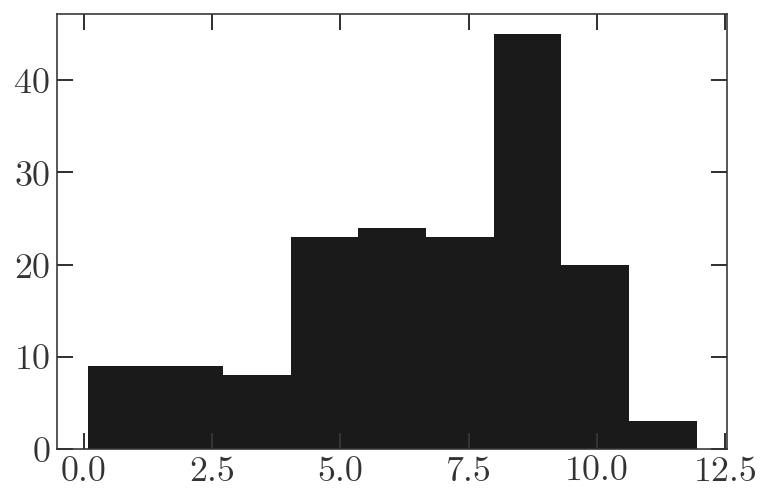

In [30]:
plt.hist(seps[seps > 0*u.pc], bins='auto')